In [1]:
import os
import sys
%matplotlib inline
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

#to set unique date for outputs
calc_date = datetime.datetime.now()
date=calc_date.strftime('%Y-%m-%d')
#date=calc_date.strftime('%d-%m-%Y')
date = date.replace('-', '')

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, dpi_save=300)

# input data and metadata

In [2]:
indexer = pd.read_csv('/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/YS_datasets_indexer.csv', index_col=0)

keys = ['YS_EL','Gastrulation','Fetal_Liver','Adult_Liver', 'Fetal_Kidney' ,'Clara_IPSC']

intersect_genes = False

adatas = {}
gene_intersect = []

for key in keys:
    adatas[key] = sc.read(indexer.loc[key]['Specific_Directory'])
    adatas[key].var_names_make_unique()
    adatas[key].obs['celltypes_anno'] = adatas[key].obs[indexer.loc[key]['Main_anno_col']]
    
    if len(keys) == 1:
        adata = list(adatas.values())[0].concatenate(list(adatas.values())[1:],join='inner')
        print('Only one dataset selected from indexer, dataset loaded as: adata')
        break
    
    if key == keys[0]:
        gene_intersect = list(adatas[key].var_names)
    else:
        gene_intersect = [gene for gene in list(adatas[key].var_names) if gene in gene_intersect]   #set(list1).intersection(list2)
        if key == keys[-1]:  
            print('All datasets loaded under dictionary: adatas')

            
metadata_addition = {
'Adult_Liver' : '/lustre/scratch117/cellgen/team298/SharedFolders/ar32/YS/Submission_Science_1/Indexers_for_scored_adult_hepatocytes.csv'
}

for key in metadata_addition.keys():
    additional_metadata = pd.read_csv(metadata_addition[key], index_col=0)
    for col in additional_metadata:
        adatas[key].obs[col] = 'nan'
        adatas[key].obs.loc[adatas[key].obs.index.isin(list(additional_metadata.index)), col] = additional_metadata[col].values
            
if intersect_genes == True:
    for dataset in adatas:
        adatas[dataset] = adatas[dataset][:,adatas[dataset].var_names.isin(gene_intersect)]

/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


All datasets loaded under dictionary: adatas


In [5]:
adatas['YS'] = sc.read('/lustre/scratch126/cellgen/team298/ar32/A2_V10_qc_raw_obsm.h5ad')

In [6]:
adatas['EL'] = sc.read('/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/A4_V8_Eliver_raw_updated_metadata_20220523.h5ad')

In [7]:
milo_out = pd.read_csv('/lustre/scratch117/cellgen/team298/SharedFolders/YS_proj/Datasets/Additional_metadata/150522_milo_ys_output.csv', index_col=0)
milo_out.index = milo_out['index_cell']

In [8]:
adatas['YS'].obs['celltypes_for_dotplot'] = adatas['YS'].obs['broad_cell_labels_organ']
adatas['YS_EL'].obs['celltypes_for_dotplot'] = adatas['YS_EL'].obs['broad_cell_labels_organ']
adatas['Gastrulation'].obs['celltypes_for_dotplot'] = adatas['Gastrulation'].obs['corr_concat']
adatas['Fetal_Liver'].obs['celltypes_for_dotplot'] = adatas['Fetal_Liver'].obs['cell.labels'].astype(str) + '_liver_not_matched'
adatas['Adult_Liver'].obs['celltypes_for_dotplot'] = adatas['Adult_Liver'].obs['scored_hepatocytes'].astype(str) + '_adult'
adatas['Fetal_Kidney'].obs['celltypes_for_dotplot'] = adatas['Fetal_Kidney'].obs['anno_to_use'].astype(str) + '_kidney'
adatas['Clara_IPSC'].obs['celltypes_for_dotplot'] = adatas['Clara_IPSC'].obs['LR_assignment_v2'].astype(str)

adatas['Adult_Liver'] = adatas['Adult_Liver'][adatas['Adult_Liver'].obs['NormalvsTumor'].isin(['Normal'])]
adatas['Adult_Liver'].obs['scored_hepatocytes'] = adatas['Adult_Liver'].obs['scored_hepatocytes'].replace('nan','not_hepatocytes', regex=True)

/tmp/ipykernel_4860/1390585486.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['Adult_Liver'].obs['scored_hepatocytes'] = adatas['Adult_Liver'].obs['scored_hepatocytes'].replace('nan','not_hepatocytes', regex=True)
/home/jovyan/my-conda-envs/YS_env/lib/python3.9/contextlib.py:124: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [9]:
adatas['EL'] = adatas['EL'][adatas['EL'].obs.index.isin(adatas['YS_EL'].obs.index)]
adatas['YS_EL'] = adatas['YS_EL'][adatas['YS_EL'].obs.index.isin(adatas['EL'].obs.index)]

adatas['EL'].obs = adatas['YS_EL'].obs.copy()

del adatas['YS_EL']

In [10]:
adatas.keys()

dict_keys(['Gastrulation', 'Fetal_Liver', 'Adult_Liver', 'Fetal_Kidney', 'Clara_IPSC', 'YS', 'EL'])

# scaling independently rarther than on loop to save on memory overflow

In [11]:
sc.pp.normalize_total(adatas['YS'], target_sum=1e4)
sc.pp.log1p(adatas['YS'])
sc.pp.scale(adatas['YS'], max_value = 10)

normalizing counts per cell
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [12]:
sc.pp.normalize_total(adatas['EL'], target_sum=1e4)
sc.pp.log1p(adatas['EL'])
sc.pp.scale(adatas['EL'], max_value = 10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [13]:
sc.pp.normalize_total(adatas['Gastrulation'], target_sum=1e4)
sc.pp.log1p(adatas['Gastrulation'])
sc.pp.scale(adatas['Gastrulation'], max_value = 10)

normalizing counts per cell
    finished (0:00:00)


In [14]:
sc.pp.normalize_total(adatas['Fetal_Liver'], target_sum=1e4)
sc.pp.log1p(adatas['Fetal_Liver'])
sc.pp.scale(adatas['Fetal_Liver'], max_value = 10)

normalizing counts per cell
    finished (0:00:01)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [15]:
sc.pp.normalize_total(adatas['Adult_Liver'], target_sum=1e4)
sc.pp.log1p(adatas['Adult_Liver'])
sc.pp.scale(adatas['Adult_Liver'], max_value = 10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [16]:
sc.pp.normalize_total(adatas['Fetal_Kidney'], target_sum=1e4)
sc.pp.log1p(adatas['Fetal_Kidney'])
sc.pp.scale(adatas['Fetal_Kidney'], max_value = 10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [17]:
sc.pp.normalize_total(adatas['Clara_IPSC'], target_sum=1e4)
sc.pp.log1p(adatas['Clara_IPSC'])
sc.pp.scale(adatas['Clara_IPSC'], max_value = 10)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [18]:
#for key in adatas:
#    sc.pp.normalize_total(adatas[key], target_sum=1e4)
#    sc.pp.log1p(adatas[key])
#    sc.pp.scale(adatas[key], max_value = 10)



adatas['Fetal_Liver'] = adatas['Fetal_Liver'][adatas['Fetal_Liver'].obs['celltypes_anno'].isin(['Hepatocyte'])]
adatas['Adult_Liver'] = adatas['Adult_Liver'][adatas['Adult_Liver'].obs['scored_hepatocytes'].isin(['scored_hepatocytes'])]
adatas['Fetal_Kidney'] = adatas['Fetal_Kidney'][adatas['Fetal_Kidney'].obs['anno_to_use'].isin(['FIBROBLAST_XI'])]
adatas['Clara_IPSC'] = adatas['Clara_IPSC'][adatas['Clara_IPSC'].obs['celltypes_for_dotplot'].isin(['Endoderm_IPSC'])]
    
adatas['EL'].obs['celltypes_for_dotplot'] = adatas['EL'].obs['broad_cell_labels_organ']



adata_list = [adatas['EL'],adatas['Gastrulation']]
adatas['adata'] = sc.AnnData.concatenate(*adata_list, join='inner', batch_categories=None ,index_unique=None) 

adatas['adata'] = adatas['adata'][adatas['adata'].obs['celltypes_for_dotplot'].isin(['Hepatocyte_fliv','YS Endoderm_Yolk Sac_gastrulation'])]

dict1 = {
'CS10' : 'CS10-11',
'CS11' : 'CS10-11',
'CS14' : 'CS14-15',
'CS15' : 'CS14-15',
'CS17' : 'CS17-18',
'CS18' : 'CS17-18',
'CS22' : 'CS22-23',
'CS23' : 'CS22-23'
}

adatas['adata'].obs['time_points'] = adatas['adata'].obs['stage'].map(dict1)
adatas['adata'].obs['time_points'] = adatas['adata'].obs['time_points'].astype(str)
adatas['adata'].obs.loc[adatas['adata'].obs['time_points'] == 'nan', 'time_points'] = 'CS7'
adatas['adata'].obs['celltypes_for_dotplot'] = adatas['adata'].obs['time_points'] + '_' + adatas['adata'].obs['tissue']

adatas['YS'].obs['time_points'] = adatas['YS'].obs['stage'].map(dict1)

adatas['YS_backup'] = adatas['YS'].copy()

obs_intersect = list(set(list(adatas['YS'].obs.index)) & set(list(milo_out.index)))

adatas['YS'] = adatas['YS'][adatas['YS'].obs.index.isin(obs_intersect)]
milo_out_intersect = milo_out[milo_out.index.isin(obs_intersect)]
#milo_out_non_intersect = milo_out[~milo_out.index.isin(obs_intersect)]

# Cut to celltype of interest
celltype = 'Endoderm'
adatas['YS'] = adatas['YS'][adatas['YS'].obs['broad_cell.labels'].isin([celltype])]
milo_out_intersect = milo_out_intersect[milo_out_intersect['nhood_anno'].isin([celltype])]

adatas['YS'].obs['nhood_Sig_FC'] = milo_out_intersect['nhood_Sig_FC']
adatas['YS'].obs['early_late_time_points'] = adatas['YS'].obs['time_points'].astype(str) + '_' + adatas['YS'].obs['nhood_Sig_FC'].astype(str)
adatas['YS'].obs['celltypes_for_dotplot'] = adatas['YS'].obs['early_late_time_points']



/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/anndata/_core/merge.py:942: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/tmp/ipykernel_4860/3287881991.py:33: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['adata'].obs['time_points'] = adatas['adata'].obs['stage'].map(dict1)
/tmp/ipykernel_4860/3287881991.py:53: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['YS'].obs['nhood_Sig_FC

In [19]:
adatas['YS_backup'] = adatas['YS_backup'][adatas['YS_backup'].obs['broad_cell.labels'].isin([celltype])]

In [20]:
adatas['YS_backup'] = adatas['YS_backup'][adatas['YS_backup'].obs['time_points'].isin(['CS22-23'])]

In [21]:
adatas['YS'] = adatas['YS'][~adatas['YS'].obs['time_points'].isin(['CS22-23'])]

In [22]:
adatas['YS_backup'].obs['celltypes_for_dotplot'] = 'CS22-23_Late'

/tmp/ipykernel_4860/3977521629.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['YS_backup'].obs['celltypes_for_dotplot'] = 'CS22-23_Late'


In [23]:
adata_list = [adatas['adata'],adatas['YS'],adatas['YS_backup']]
adatas['adata'] = sc.AnnData.concatenate(*adata_list, join='inner', batch_categories=None ,index_unique=None) 

/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [24]:
#adatas['adata'].obs.replace({'celltypes_for_dotplot':'CS22-23_False'},'CS22-23_Late',inplace=True)
adatas['adata'] = adatas['adata'][~adatas['adata'].obs['celltypes_for_dotplot'].str.contains('False')]
adatas['adata'] = adatas['adata'][~adatas['adata'].obs['celltypes_for_dotplot'].str.contains('CS14-15_Late')]

In [25]:
adatas['Fetal_Liver'].obs['celltypes_for_dotplot'] = 'fetal_liver'
adatas['Adult_Liver'].obs['celltypes_for_dotplot'] = 'adult_liver'
adatas['Fetal_Kidney'].obs['celltypes_for_dotplot'] = 'fetal_kidney'
adatas['Clara_IPSC'].obs['celltypes_for_dotplot'] = 'IPSC' 

/tmp/ipykernel_4860/4088774343.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['Fetal_Liver'].obs['celltypes_for_dotplot'] = 'fetal_liver'
/tmp/ipykernel_4860/4088774343.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['Adult_Liver'].obs['celltypes_for_dotplot'] = 'adult_liver'
/tmp/ipykernel_4860/4088774343.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['Fetal_Kidney'].obs['celltypes_for_dotplot'] = 'fetal_kidney'
/tmp/ipykernel_4860/4088774343.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['Clara_IPSC'].obs['celltypes_for_dotplot'] = 'IPSC'


In [26]:
adata_list = [adatas['adata'],adatas['Fetal_Liver'],adatas['Adult_Liver'],adatas['Fetal_Kidney'],adatas['Clara_IPSC']]
adatas['adata'] = sc.AnnData.concatenate(*adata_list, join='inner', batch_categories=None ,index_unique=None)

/home/jovyan/my-conda-envs/YS_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [27]:
adatas['adata'].obs['celltypes_for_dotplot'].value_counts()

CS17-18_Liver       7893
fetal_liver         2170
IPSC                1623
CS22-23_Liver        335
fetal_kidney         120
CS10-11_Early         95
CS17-18_Early         81
adult_liver           67
CS7_gastrulation      49
CS22-23_Late          42
CS14-15_Early         36
CS17-18_Late           5
CS14-15_nan            2
Name: celltypes_for_dotplot, dtype: int64

In [28]:
adatas['adata'].obs[adatas['adata'].obs['celltypes_for_dotplot'] == 'CS14-15_nan']

cell.labels stage  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...      HSPC_2  CS14   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...      HSPC_2  CS14   

                                                             lanes     sex  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...  FCAImmP7504911  Female   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...  FCAImmP7504912  Female   

                                                   sort.ids fetal.ids  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...    Total       F37   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...    Total       F37   

                                                   component  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...  Membrane   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...  Membrane   

                                                   broad_cell.labels  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...          Endoderm   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...          Endoderm   

                                                   sequencing.type  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...          3prime   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...          3prime   

                                                                 orig.dataset  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...  Popescu_et_al_Nature_2019   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...  Popescu_et_al_Nature_2019   

                                                    ...  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...  ...   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...  ...   

                                                   GON_LRda1007_AUCauc09953len98forAGGmtested103  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...                                           NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...                                           NaN   

                                                   GON_LRda1007_AUCauc09971len152forAGGmtested154  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...                                            NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...                                            NaN   

                                                   GON_LRda1007_AUCauc09979len204forAGGmtested205  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...                                            NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...                                            NaN   

                                                   GON_LRda1107_AUCauc09987len7forAGGmtested52  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...                                         NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...                                         NaN   

                                                   GON_LRda1107_AUCauc1len77forAGGmtested103  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...                                       NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...                                       NaN   

                                                   GON_LRda1107_AUCauc1len77forAGGmtested154  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...                                       NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...                                       NaN   

                                                   GON_LRda1107_AUCauc1len77forAGGmtested205  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...                                       NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...                                       NaN   

                                                   tissue_fetal_id  \
F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGT...             NaN   
F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTG...             NaN   

                                                   LR_

In [29]:
adatas['adata_cut_manual'] = adatas['adata'].copy()

In [30]:
adatas['adata_cut_manual'] = adatas['adata_cut_manual'][~adatas['adata_cut_manual'].obs.index.isin(['F37_Yolksac_Total_FCAImmP7504911_ATTGGTGGTTGAGTTC-0' , 'F37_Yolksac_Total_FCAImmP7504912_TTAGGACCAAGTTGTC-0'])]

In [31]:
adatas['adata_cut_manual'].obs['celltypes_for_dotplot'].value_counts()

CS17-18_Liver       7893
fetal_liver         2170
IPSC                1623
CS22-23_Liver        335
fetal_kidney         120
CS10-11_Early         95
CS17-18_Early         81
adult_liver           67
CS7_gastrulation      49
CS22-23_Late          42
CS14-15_Early         36
CS17-18_Late           5
Name: celltypes_for_dotplot, dtype: int64

In [32]:
adatas['adata_cut_manual']

View of AnnData object with n_obs × n_vars = 12516 × 16535
    obs: 'cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'organ', 'donor', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2_num', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pval', 'scr_pval', 'scr_doublet_call_default', 'scrublet_leiden_R', 'cell.labels_150522', 'cell.labels_170522', 'cell.labels_170522_v2', 'legacy_broad_cell.labels_20220519', 'V5_indexes', 'barcodes', 'celltypes_anno', 'celltypes_for_d

/tmp/ipykernel_4860/1061767996.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adatas['adata_cut_manual'].obs['celltypes_for_dotplot'] = adatas['adata_cut_manual'].obs['celltypes_for_dotplot'].astype('category')


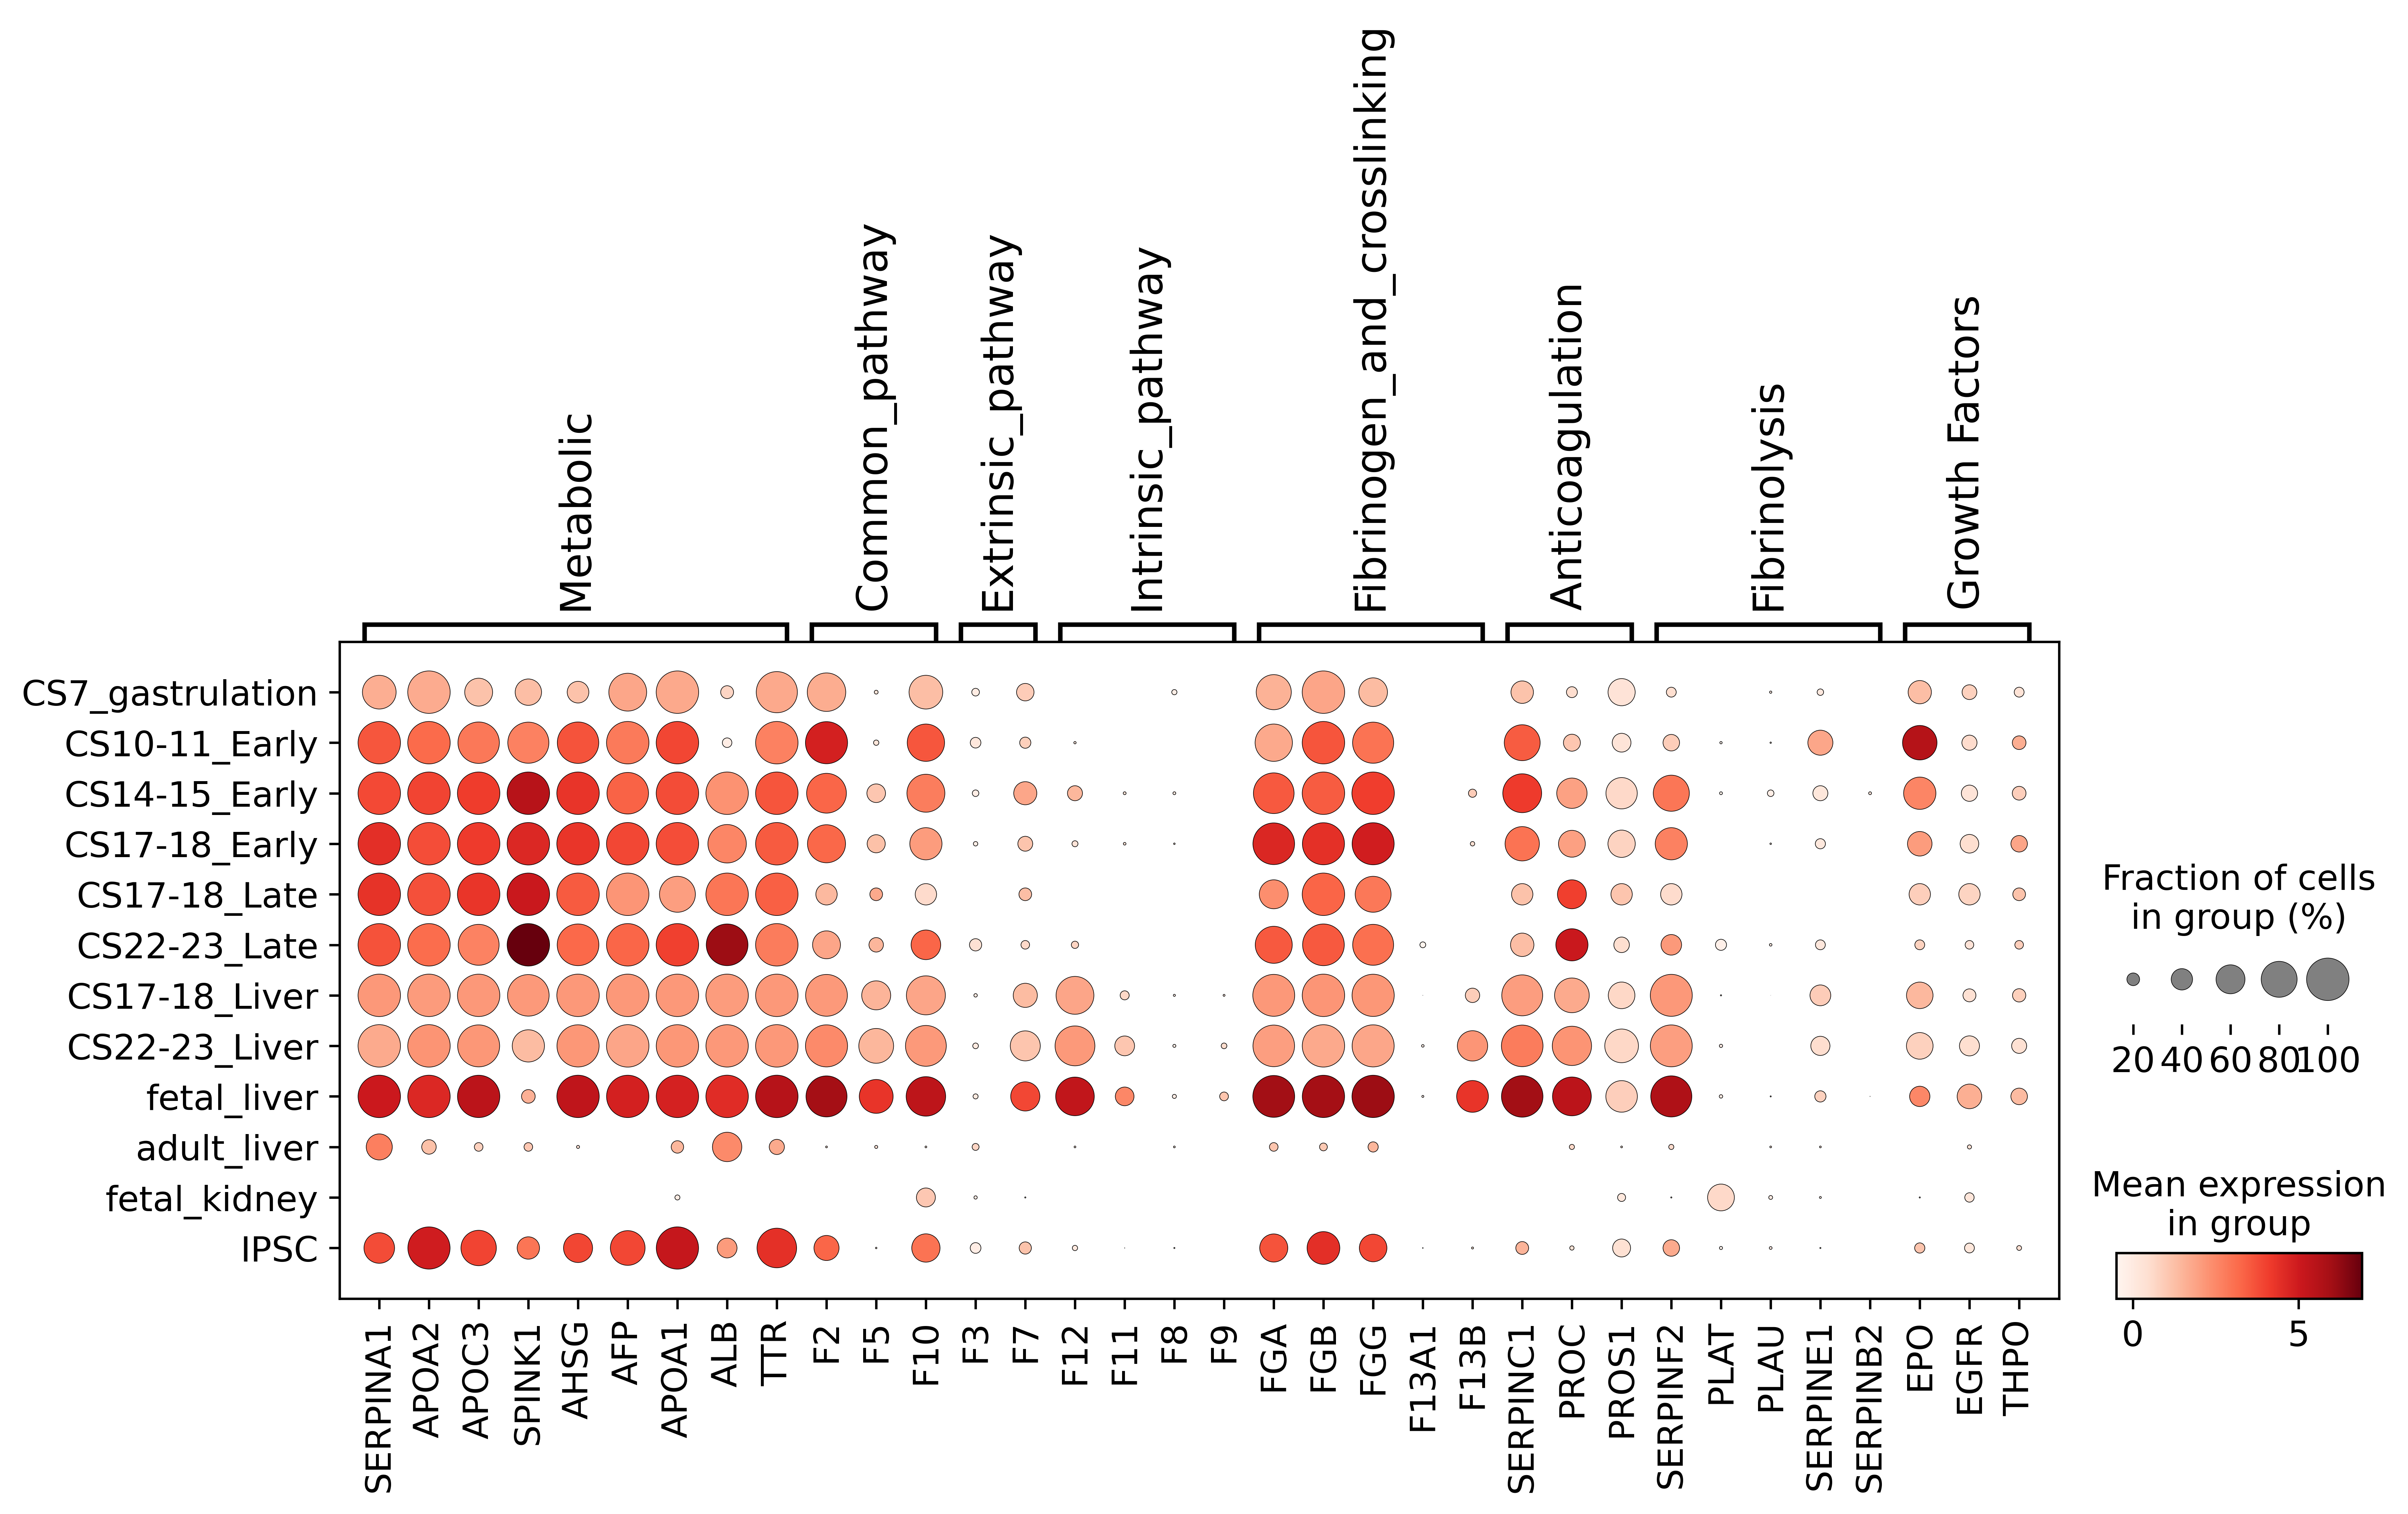

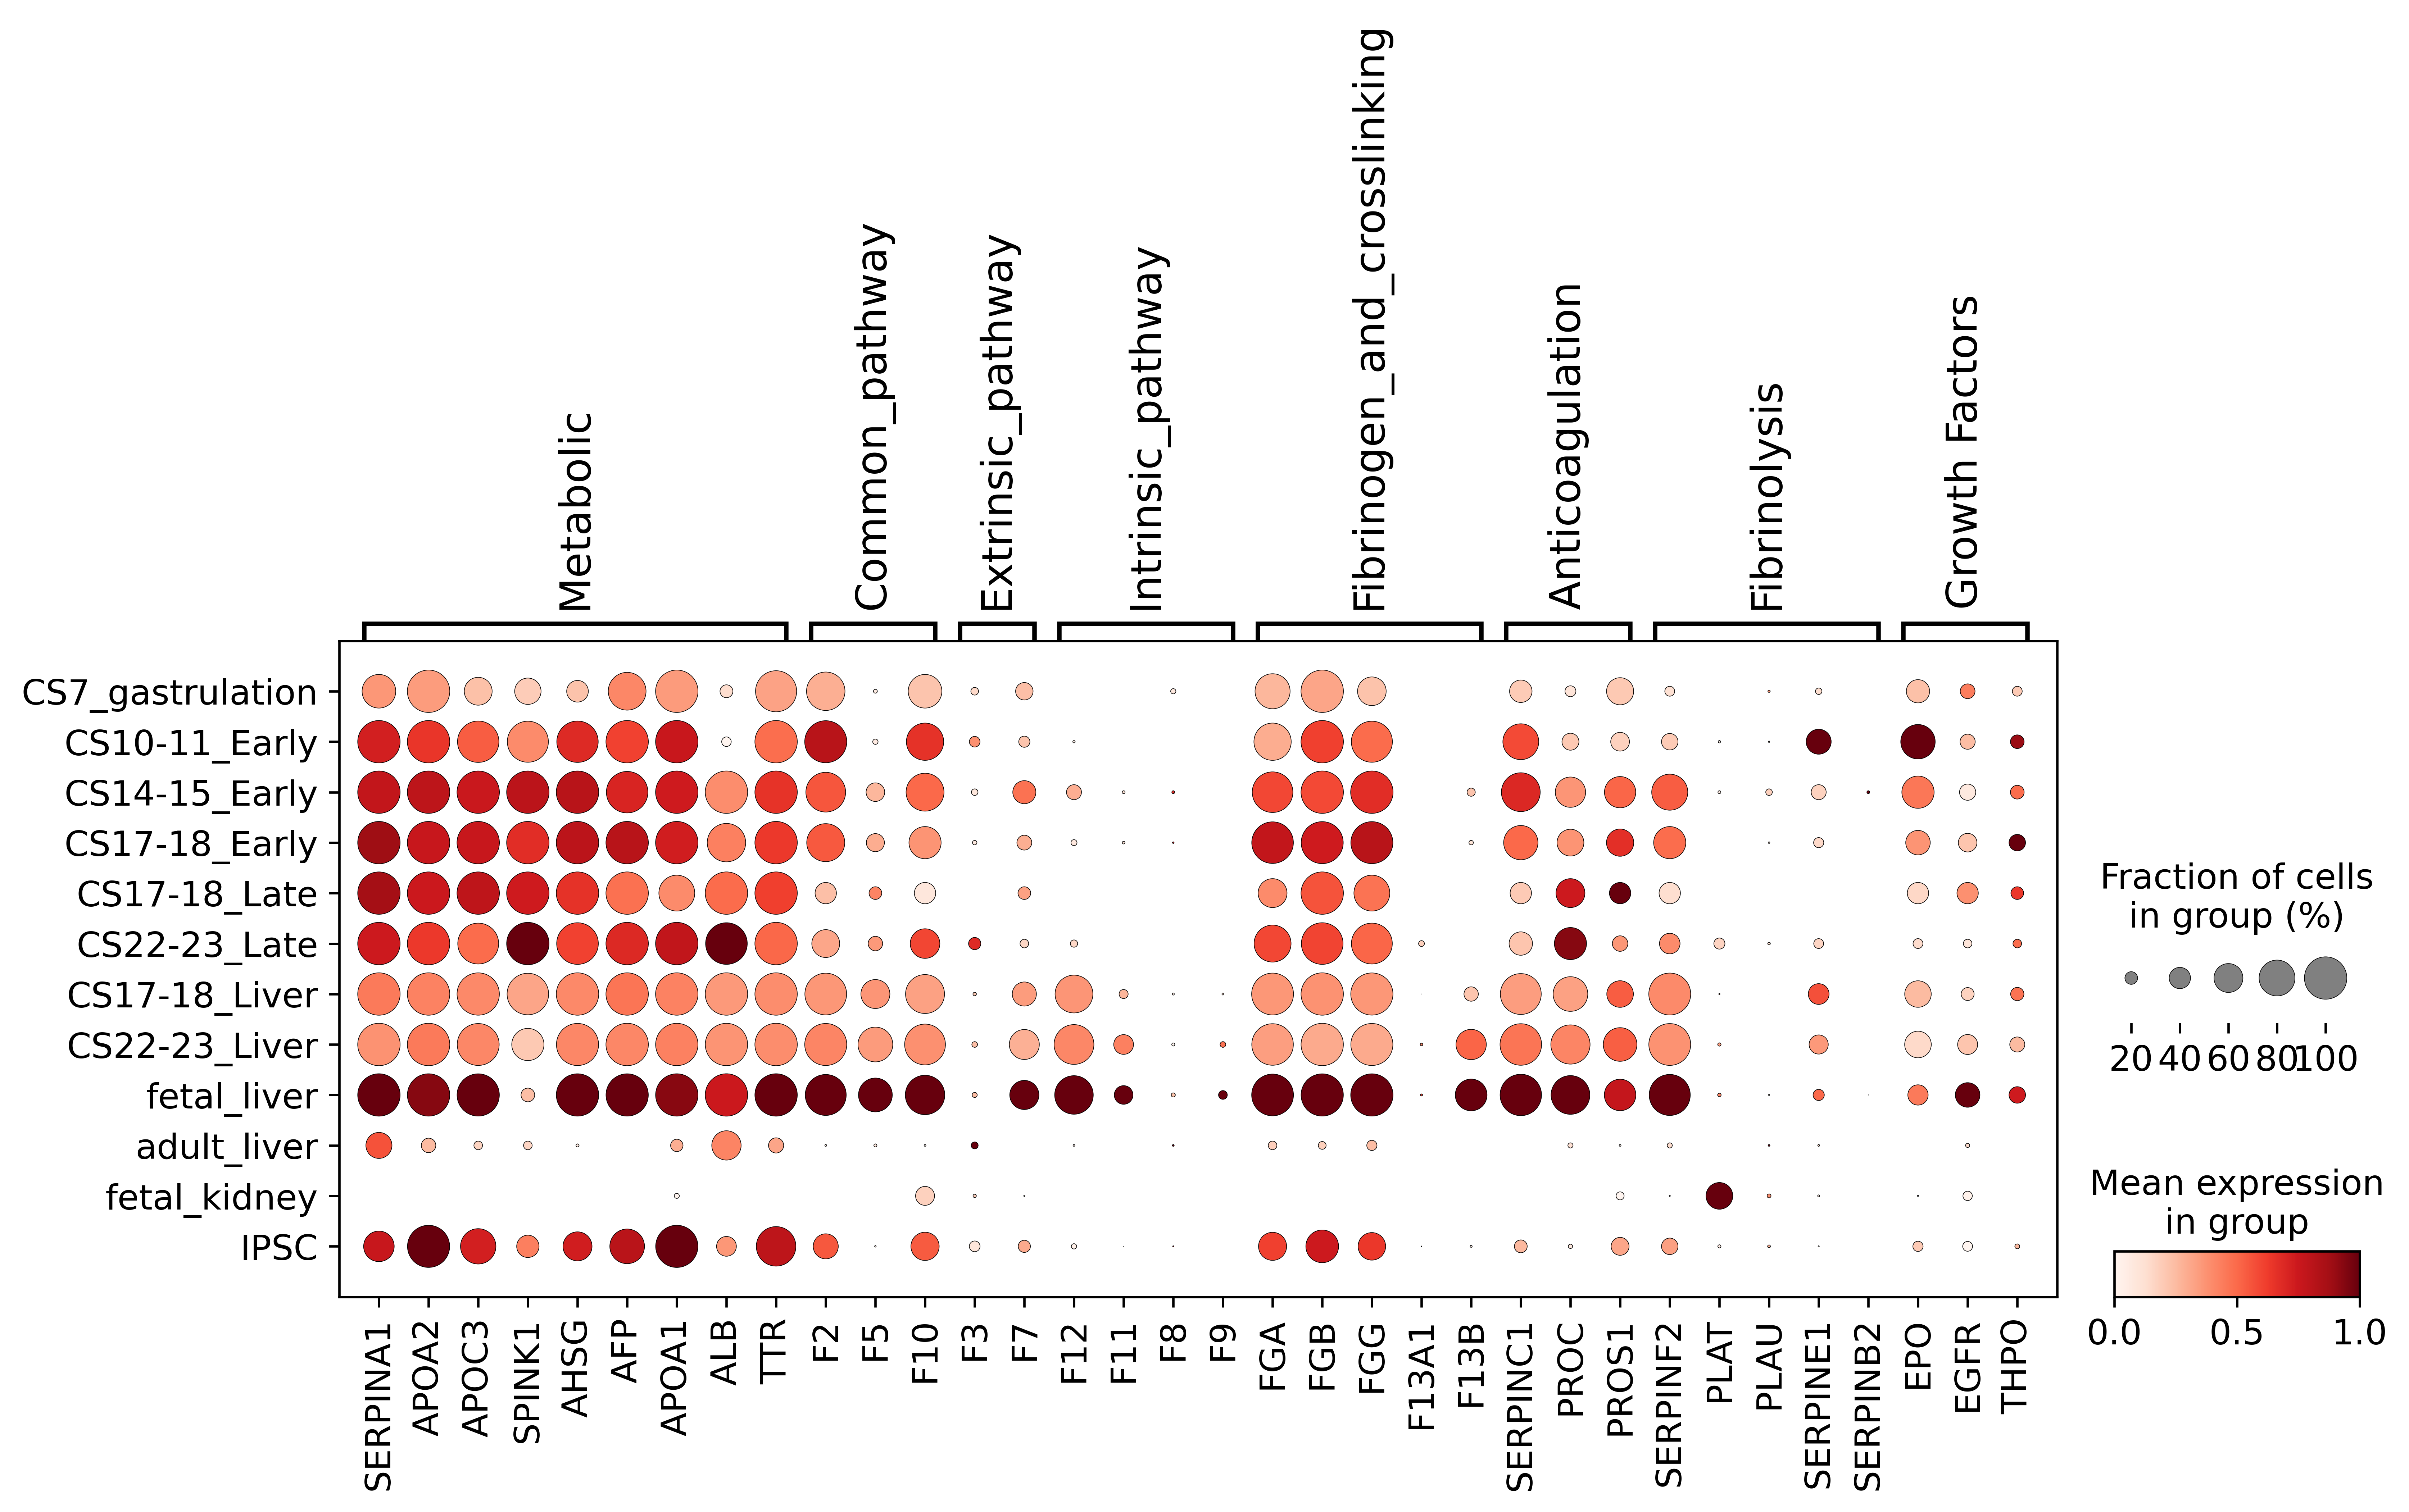

In [33]:
genes = {
    'Metabolic':['SERPINA1','APOA2','APOC3','SPINK1','AHSG','AFP','APOA1','ALB','TTR'],
    'Common_pathway':['F2','F5','F10'],
    'Extrinsic_pathway':['F3','F7'],
    'Intrinsic_pathway':['F12','F11','F8','F9'], #added F9
    'Fibrinogen_and_crosslinking':['FGA','FGB','FGG','F13A1','F13B'],
    'Anticoagulation':['SERPINC1','PROC','PROS1'],
    'Fibrinolysis':['SERPINF2','PLAT','PLAU','SERPINE1','SERPINB2'], # 'SERPINB2' = 'PAI2'
    #'EPO_module':['EPO','EGFR','THPO','TNFSF12','EPHA1']
    'Growth Factors':['EPO','EGFR','THPO',]
}

groups = [
'CS7_gastrulation',    
'CS10-11_Early',
'CS14-15_Early', 
'CS17-18_Early',
'CS17-18_Late',
'CS22-23_Late',  
'CS17-18_Liver',
'CS22-23_Liver',
'fetal_liver',  
'adult_liver',
'fetal_kidney',
'IPSC',
]


adatas['adata_cut_manual'].obs['celltypes_for_dotplot'] = adatas['adata_cut_manual'].obs['celltypes_for_dotplot'].astype('category')
adatas['adata_cut_manual'].obs['celltypes_for_dotplot'] = adatas['adata_cut_manual'].obs['celltypes_for_dotplot'].cat.reorder_categories(groups)

sc.pl.dotplot(adatas['adata_cut_manual'], var_names=genes, groupby='celltypes_for_dotplot', swap_axes=False, figsize=(12,4), use_raw=False,) #save='YS_main_fig2e_{d}.pdf'.format(d=date)
sc.pl.dotplot(adatas['adata_cut_manual'], var_names=genes, groupby='celltypes_for_dotplot', swap_axes=False, figsize=(12,4), use_raw=False, standard_scale='var' ) #save='YS_main_fig2e_{d}.pdf'.format(d=date)

In [42]:
date

'20230327'

In [39]:
sc.settings.set_figure_params(dpi=80, dpi_save=300)

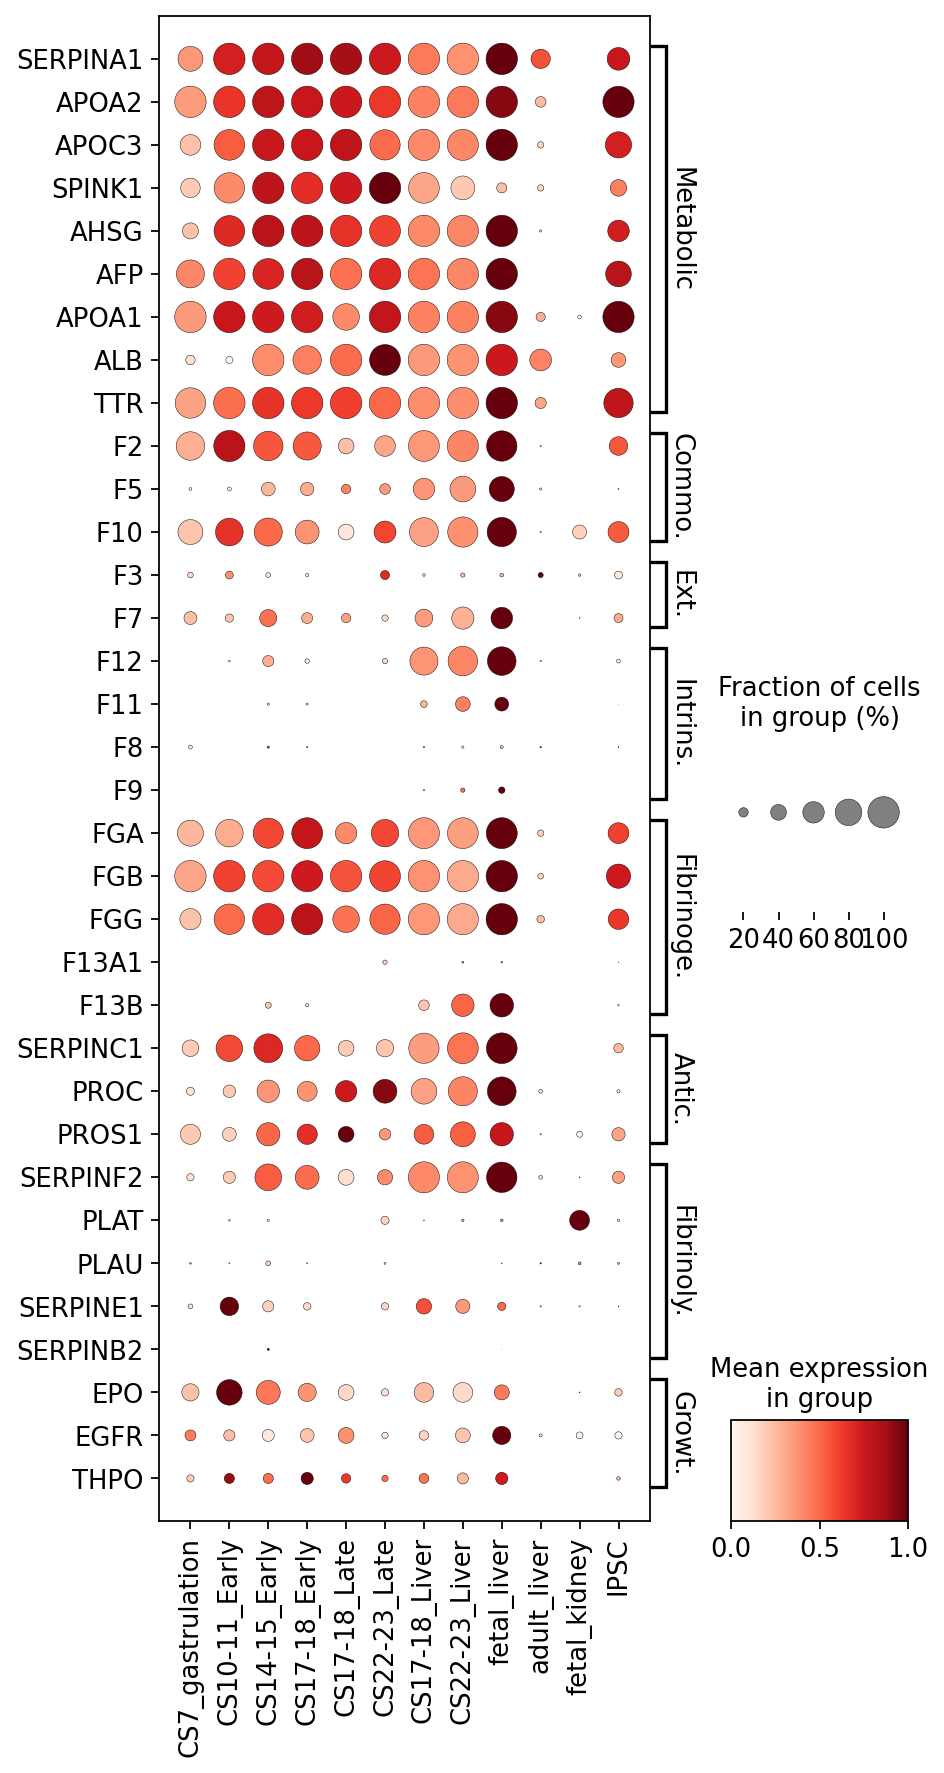

In [43]:
sc.pl.dotplot(adatas['adata_cut_manual'], var_names=genes, groupby='celltypes_for_dotplot', swap_axes=True, figsize=(6,12), use_raw=False, standard_scale='var',save='YS_main_fig2e_{d}.pdf'.format(d=date) ) #save='YS_main_fig2e_{d}.pdf'.format(d=date)

In [48]:
obs = adatas['adata_cut_manual'].obs.copy()

In [49]:
obs.to_csv('adata_cut_manual_obs.csv')

In [53]:
adatas['adata_cut_manual'].obs = adatas['adata_cut_manual'].obs[['celltypes_for_dotplot']]
adatas['adata_cut_manual'].obs

celltypes_for_dotplot
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCAAGTAATG         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_AACCATGGTGTTAAGA         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_ACACTGAAGCCAGTTT         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_ACGTCAAAGGTGCTAG         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_ACTGAACTCCGCGTTT         CS17-18_Liver
...                                                               ...
CTGATAGTCTTTCCTC-16                                              IPSC
CTGCGGAAGCGTCTAT-16                                              IPSC
GATCTAGAGCGATGAC-16                                              IPSC
GTAACGTTCAGTCCCT-16                                              IPSC
TCTTCGGGTCTGCCAG-16                                              IPSC

[12516 rows x 1 columns]

In [54]:
adatas['adata_cut_manual'].write('fig2d_object_out_20230327.h5ad')

In [ ]:
adatas['adata']

In [55]:
obs2 = adatas['adata'].obs.copy()

In [56]:
obs2.to_csv('adata_before_cut_manual_obs.csv')

In [57]:
adatas['adata'].obs = adatas['adata'].obs[['celltypes_for_dotplot']]
adatas['adata'].obs

celltypes_for_dotplot
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCAAGTAATG         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_AACCATGGTGTTAAGA         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_ACACTGAAGCCAGTTT         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_ACGTCAAAGGTGCTAG         CS17-18_Liver
F61_Liver_CD45+_FCAImmP7862084_ACTGAACTCCGCGTTT         CS17-18_Liver
...                                                               ...
CTGATAGTCTTTCCTC-16                                              IPSC
CTGCGGAAGCGTCTAT-16                                              IPSC
GATCTAGAGCGATGAC-16                                              IPSC
GTAACGTTCAGTCCCT-16                                              IPSC
TCTTCGGGTCTGCCAG-16                                              IPSC

[12518 rows x 1 columns]

In [58]:
adatas['adata'].write('fig2d_object_out_before_manual_cut_20230327.h5ad')

In [4]:
%%bash

cp /nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad /lustre/scratch126/cellgen/team298/ar32/